In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
# PATH
DATA_PATH  = '../DATA'
TRAIN_PATH = os.path.join(DATA_PATH, 'train')
TRAIN_CSV  = os.path.join(DATA_PATH, 'train.csv')
SAMPLE_PATH = os.path.join(DATA_PATH, 'sample_submission.csv')
LABEL_PATH = os.path.join(DATA_PATH, 'label.csv')

In [4]:
df_train = pd.read_csv(TRAIN_CSV)
df_train.head()

,일자,종목코드,종목명,거래량,시가,고가,저가,종가
0,20210601,A060310,3S,166690,2890,2970,2885,2920
1,20210601,A095570,AJ네트웍스,63836,5860,5940,5750,5780
2,20210601,A006840,AK홀딩스,103691,35500,35600,34150,34400
3,20210601,A054620,APS,462544,14600,14950,13800,14950
4,20210601,A265520,AP시스템,131987,29150,29150,28800,29050


In [6]:
ss= pd.read_csv(SAMPLE_PATH)
ss

,종목코드,순위
0,A000020,1
1,A000040,2
2,A000050,3
3,A000070,4
4,A000080,5
...,...,...
1995,A375500,1996
1996,A378850,1997
1997,A383220,1998
1998,A383310,1999


In [7]:
# Training 데이터 로드
df_train = pd.read_csv(TRAIN_CSV)
df_train['일자'] = pd.to_datetime(df_train['일자'], format='%Y%m%d')

# 순위 데이터 로드
ss = pd.read_csv('/Users/admin/Documents/GitHub/Dacon_stock_price_prediction/DATA/results/20230714_143756/submission.csv')

# 매매 기록을 담을 DataFrame 생성
trade_log = pd.DataFrame(columns=['일자', 'Buy', 'Sell', 'Profit'])

# 전일 종가에 매수, 다음날 종가에 매도
for date in df_train['일자'].unique():
    if date != df_train['일자'].max():  # 마지막 거래일 제외
        # 해당 일자의 데이터만 추출
        df_date = df_train[df_train['일자'] == date]
        
        # 순위에 따라 상위 200개 종목 매수, 하위 200개 종목 매도
        buy_stocks = ss[:200]['종목코드']
        sell_stocks = ss[-200:]['종목코드']
        
        # 매수, 매도 종목의 종가 합 계산
        buy_sum = df_date[df_date['종목코드'].isin(buy_stocks)]['종가'].sum()
        sell_sum = df_date[df_date['종목코드'].isin(sell_stocks)]['종가'].sum()
        
        # 이익 계산
        profit = buy_sum - sell_sum

        # 매매 기록 저장
        trade_log = trade_log.append({'일자': date, 'Buy': buy_sum, 'Sell': sell_sum, 'Profit': profit}, ignore_index=True)

# 이익률 계산 (이익을 매수 종목의 전일 종가 합으로 나눔)
trade_log['Return'] = trade_log['Profit'] / trade_log['Buy']

# Sharpe Ratio 계산 (무위험 수익률을 0으로 가정)
mean_return = trade_log['Return'].mean()
std_return = trade_log['Return'].std()
sharpe_ratio = mean_return / std_return

print('Sharpe Ratio: ', sharpe_ratio)


/var/folders/nh/_4ldy_ss7yv872vc0r53p2jw0000gn/T/ipykernel_8792/3069213526.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trade_log = trade_log.append({'일자': date, 'Buy': buy_sum, 'Sell': sell_sum, 'Profit': profit}, ignore_index=True)
/var/folders/nh/_4ldy_ss7yv872vc0r53p2jw0000gn/T/ipykernel_8792/3069213526.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trade_log = trade_log.append({'일자': date, 'Buy': buy_sum, 'Sell': sell_sum, 'Profit': profit}, ignore_index=True)
/var/folders/nh/_4ldy_ss7yv872vc0r53p2jw0000gn/T/ipykernel_8792/3069213526.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trade_log = trade_log.append({'일자': date, 'Buy': buy_sum, 'Sell': sell_sum, 'Profit': profit}, ignore_index=True)
/var/fo

Sharpe Ratio:  7.592856526023794


/var/folders/nh/_4ldy_ss7yv872vc0r53p2jw0000gn/T/ipykernel_8792/3069213526.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trade_log = trade_log.append({'일자': date, 'Buy': buy_sum, 'Sell': sell_sum, 'Profit': profit}, ignore_index=True)
/var/folders/nh/_4ldy_ss7yv872vc0r53p2jw0000gn/T/ipykernel_8792/3069213526.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trade_log = trade_log.append({'일자': date, 'Buy': buy_sum, 'Sell': sell_sum, 'Profit': profit}, ignore_index=True)
/var/folders/nh/_4ldy_ss7yv872vc0r53p2jw0000gn/T/ipykernel_8792/3069213526.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trade_log = trade_log.append({'일자': date, 'Buy': buy_sum, 'Sell': sell_sum, 'Profit': profit}, ignore_index=True)
/var/fo

In [11]:
df_train

,일자,종목코드,종목명,거래량,시가,고가,저가,종가
0,2021-06-01,A060310,3S,166690,2890,2970,2885,2920
1,2021-06-01,A095570,AJ네트웍스,63836,5860,5940,5750,5780
2,2021-06-01,A006840,AK홀딩스,103691,35500,35600,34150,34400
3,2021-06-01,A054620,APS,462544,14600,14950,13800,14950
4,2021-06-01,A265520,AP시스템,131987,29150,29150,28800,29050
...,...,...,...,...,...,...,...,...
987995,2023-05-30,A189980,흥국에프엔비,272284,3005,3035,2955,2980
987996,2023-05-30,A000540,흥국화재,50218,3250,3255,3195,3215
987997,2023-05-30,A003280,흥아해운,130664,1344,1395,1340,1370
987998,2023-05-30,A037440,희림,141932,9170,9260,9170,9200


In [9]:
# Training 데이터 로드
df_train = pd.read_csv(TRAIN_CSV)
df_train['일자'] = pd.to_datetime(df_train['일자'], format='%Y%m%d')

# 순위 데이터 로드
ss = pd.read_csv('/Users/admin/Documents/GitHub/Dacon_stock_price_prediction/DATA/results/20230714_143756/submission1.csv')

# 매매 기록을 담을 리스트 생성
trade_log = []

# 전일 종가에 매수, 다음날 종가에 매도
for date in df_train['일자'].unique():
    if date != df_train['일자'].max():  # 마지막 거래일 제외
        # 해당 일자의 데이터만 추출
        df_date = df_train[df_train['일자'] == date]
        
        # 순위에 따라 상위 200개 종목 매수, 하위 200개 종목 매도
        buy_stocks = ss[:200]['종목코드']
        sell_stocks = ss[-200:]['종목코드']
        
        # 매수, 매도 종목의 종가 합 계산
        buy_sum = df_date[df_date['종목코드'].isin(buy_stocks)]['종가'].sum()
        sell_sum = df_date[df_date['종목코드'].isin(sell_stocks)]['종가'].sum()
        
        # 이익 계산
        profit = buy_sum - sell_sum

        # 매매 기록 저장
        trade_log.append({'일자': date, 'Buy': buy_sum, 'Sell': sell_sum, 'Profit': profit})

# 매매 기록을 DataFrame으로 변환
trade_log_df = pd.DataFrame(trade_log)

# 이익률 계산 (이익을 매수 종목의 전일 종가 합으로 나눔)
trade_log_df['Return'] = trade_log_df['Profit'] / trade_log_df['Buy']

# Sharpe Ratio 계산 (무위험 수익률을 0으로 가정)
mean_return = trade_log_df['Return'].mean()
std_return = trade_log_df['Return'].std()
sharpe_ratio = mean_return / std_return

print('Sharpe Ratio: ', sharpe_ratio)


Sharpe Ratio:  7.592856526023796


In [12]:
# Training 데이터 로드
df_train = pd.read_csv(TRAIN_CSV)
df_train['일자'] = pd.to_datetime(df_train['일자'], format='%Y%m%d')

# 순위 데이터 로드
ss = pd.read_csv('/Users/admin/Documents/GitHub/Dacon_stock_price_prediction/DATA/results/20230714_231634/submission.csv')

# 매매 기록을 담을 리스트 생성
trade_log = []

# 전일 종가에 매수, 다음날 종가에 매도
for date in df_train['일자'].unique():
    if date != df_train['일자'].max():  # 마지막 거래일 제외
        # 해당 일자의 데이터만 추출
        df_date = df_train[df_train['일자'] == date]
        
        # 순위에 따라 상위 200개 종목 매수, 하위 200개 종목 매도
        buy_stocks = ss[:200]['종목코드']
        sell_stocks = ss[-200:]['종목코드']
        
        # 매수, 매도 종목의 종가 합 계산
        buy_sum = df_date[df_date['종목코드'].isin(buy_stocks)]['종가'].sum()
        sell_sum = df_date[df_date['종목코드'].isin(sell_stocks)]['종가'].sum()
        
        # 이익 계산
        profit = buy_sum - sell_sum

        # 매매 기록 저장
        trade_log.append({'일자': date, 'Buy': buy_sum, 'Sell': sell_sum, 'Profit': profit})

# 매매 기록을 DataFrame으로 변환
trade_log_df = pd.DataFrame(trade_log)

# 이익률 계산 (이익을 매수 종목의 전일 종가 합으로 나눔)
trade_log_df['Return'] = trade_log_df['Profit'] / trade_log_df['Buy']

# Sharpe Ratio 계산 (무위험 수익률을 0으로 가정)
mean_return = trade_log_df['Return'].mean()
std_return = trade_log_df['Return'].std()
sharpe_ratio = mean_return / std_return

print('Sharpe Ratio: ', sharpe_ratio)


Sharpe Ratio:  4.12112059837586


In [8]:
trade_log

,일자,Buy,Sell,Profit,Return
0,2021-06-01,11991554,7177858,4813696,0.401424
1,2021-06-02,11952638,7205639,4746999,0.397151
2,2021-06-03,11977268,7223629,4753639,0.396888
3,2021-06-04,11945902,7212003,4733899,0.396278
4,2021-06-07,11912742,7213921,4698821,0.394437
...,...,...,...,...,...
488,2023-05-22,12014074,4350978,7663096,0.637843
489,2023-05-23,12093451,4361699,7731752,0.639334
490,2023-05-24,12050492,4354580,7695912,0.638639
491,2023-05-25,11894613,4323398,7571215,0.636525


In [44]:
# from pykrx import stock

# df_list = []
# for item in tqdm(df_train['종목코드'].unique()):
#     df = stock.get_market_ohlcv_by_date("2023-05-31", "2023-06-30", item[1:])
#     df['종목코드'] = item
#     df_list.append(df)
# final_df = pd.concat(df_list)
# final_df.to_csv(LABEL_PATH, index=True)


In [4]:
final_df = pd.read_csv(LABEL_PATH)
final_df.head()

,날짜,시가,고가,저가,종가,거래량,거래대금,등락률,종목코드
0,2023-05-31,2995,3445,2935,3020,40162146,128834191830,0.17,A060310
1,2023-06-01,3000,3070,2850,2900,5019544,14708943755,-3.97,A060310
2,2023-06-02,2905,2950,2825,2875,2358195,6798794605,-0.86,A060310
3,2023-06-05,2850,3220,2785,2935,18938294,57564475670,2.09,A060310
4,2023-06-07,2890,3060,2855,2890,4640916,13739139530,-1.53,A060310


In [27]:
final_df.columns

Index(['날짜', '시가', '고가', '저가', '종가', '거래량', '종목코드'], dtype='object')

In [7]:
FEATURES = ['날짜', '시가', '고가', '저가', '종가', '거래량', '종목코드']
final_df = final_df[FEATURES]
final_df

,날짜,시가,고가,저가,종가,거래량,종목코드
0,2023-05-31,2995,3445,2935,3020,40162146,A060310
1,2023-06-01,3000,3070,2850,2900,5019544,A060310
2,2023-06-02,2905,2950,2825,2875,2358195,A060310
3,2023-06-05,2850,3220,2785,2935,18938294,A060310
4,2023-06-07,2890,3060,2855,2890,4640916,A060310
...,...,...,...,...,...,...,...
43995,2023-06-26,7900,7900,7390,7490,113422,A238490
43996,2023-06-27,7500,7550,7360,7420,56069,A238490
43997,2023-06-28,7420,7560,7410,7480,53417,A238490
43998,2023-06-29,7620,7620,7330,7400,58670,A238490


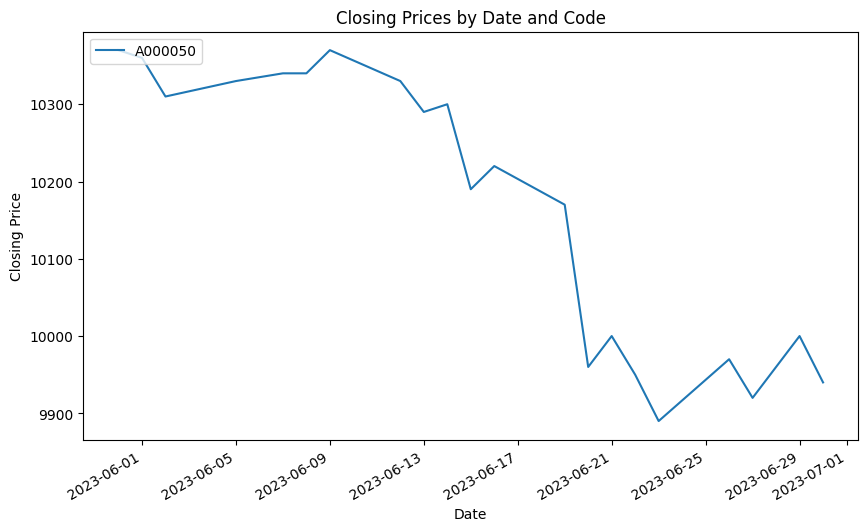

In [33]:
# 날짜별 코드별로 정렬
# Pivot the dataframe to have dates as index and codes as columns
pivot_df = final_df.pivot(index='날짜', columns='종목코드', values='종가')

# Plot the closing prices
pivot_df[pivot_df.columns[2]].plot(figsize=(10, 6))
plt.title('Closing Prices by Date and Code')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend(loc='upper left')
plt.show()


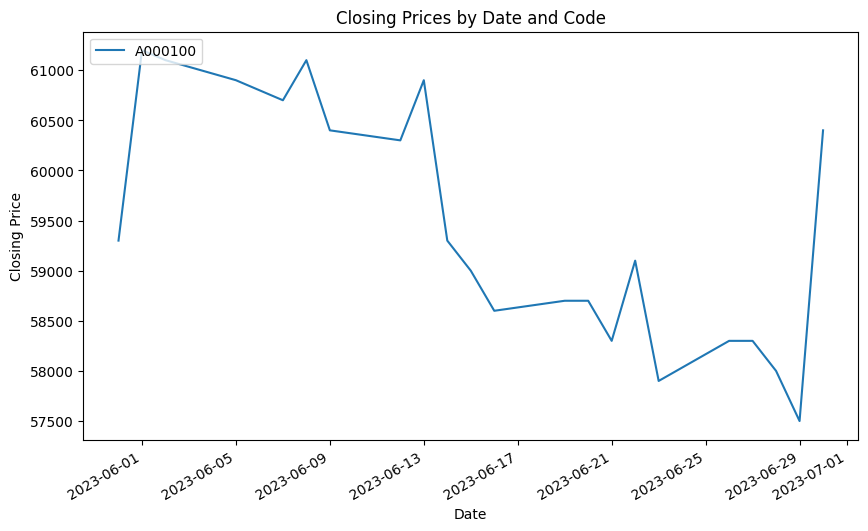

In [36]:
# Plot the closing prices
pivot_df[pivot_df.columns[5]].plot(figsize=(10, 6))
plt.title('Closing Prices by Date and Code')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend(loc='upper left')
plt.show()


In [8]:
final_df['날짜'] = pd.to_datetime(final_df['날짜'])
final_df = final_df.sort_values(by=['종목코드', '날짜'])
final_df

,날짜,시가,고가,저가,종가,거래량,종목코드
11044,2023-05-31,9610,9740,9500,9600,155397,A000020
11045,2023-06-01,9610,10080,9600,10080,239297,A000020
11046,2023-06-02,10160,10190,10040,10070,169536,A000020
11047,2023-06-05,10130,10200,9870,10110,177016,A000020
11048,2023-06-07,10120,10170,9940,10010,141026,A000020
...,...,...,...,...,...,...,...
3207,2023-06-26,7980,8010,7920,8010,61344,A383800
3208,2023-06-27,8010,8020,7960,7980,122079,A383800
3209,2023-06-28,7980,8010,7960,7970,88379,A383800
3210,2023-06-29,7960,7960,7890,7890,123014,A383800


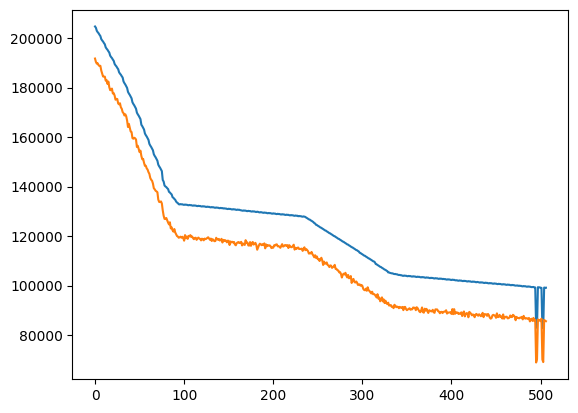

In [26]:
plt.plot(df_predictions[999].yhat)
plt.plot(df_predictions[999].yhat_lower)
plt.plot(final_df)

In [ ]:
code = 999
df_predictions[999]

In [24]:
import pandas as pd
from tqdm import tqdm

df_predictions = pd.read_pickle('/Users/admin/Documents/GitHub/Dacon_stock_price_prediction/DATA/predictions_dict.pkl') 




 20%|█▉        | 399/2000 [00:37<02:29, 10.74it/s]


KeyboardInterrupt: 

In [ ]:
fin_df = fin_df.rename(columns={'ds':'date'})

In [16]:
dd = pd.concat(df_predictions.values())
dd

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-06-03,200157.500200,191776.710871,218186.744673,200157.500200,200157.500200,4587.479904,4587.479904,4587.479904,4587.479904,4587.479904,4587.479904,0.0,0.0,0.0,204744.980104
1,2021-06-04,199679.913832,190418.179159,216571.972276,199679.913832,199679.913832,4550.433380,4550.433380,4550.433380,4550.433380,4550.433380,4550.433380,0.0,0.0,0.0,204230.347213
2,2021-06-07,198247.154729,189711.340753,215990.465885,198247.154729,198247.154729,4752.795970,4752.795970,4752.795970,4752.795970,4752.795970,4752.795970,0.0,0.0,0.0,202999.950699
3,2021-06-08,197769.568361,189847.491716,215965.500626,197769.568361,197769.568361,4674.331099,4674.331099,4674.331099,4674.331099,4674.331099,4674.331099,0.0,0.0,0.0,202443.899460
4,2021-06-09,197291.981993,189090.029310,214577.723770,197291.981993,197291.981993,4722.303008,4722.303008,4722.303008,4722.303008,4722.303008,4722.303008,0.0,0.0,0.0,202014.285001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
502,2023-06-10,633.182544,533.590761,656.047964,632.814374,633.562401,-37.034968,-37.034968,-37.034968,-37.034968,-37.034968,-37.034968,0.0,0.0,0.0,596.147576
503,2023-06-11,633.974243,536.215032,658.001149,633.505577,634.470122,-37.035028,-37.035028,-37.035028,-37.035028,-37.035028,-37.035028,0.0,0.0,0.0,596.939215
504,2023-06-12,634.765943,586.156120,712.334804,634.145016,635.417801,13.842647,13.842647,13.842647,13.842647,13.842647,13.842647,0.0,0.0,0.0,648.608589
505,2023-06-13,635.557642,591.657686,713.307968,634.739773,636.379277,16.273653,16.273653,16.273653,16.273653,16.273653,16.273653,0.0,0.0,0.0,651.831295


In [15]:
df

,날짜,예측_x,종목코드_x,예측_y,종목코드_y
0,2021-06-03,1284.632591,1,1284.632591,1
1,2021-06-04,1284.643244,1,1284.643244,1
2,2021-06-07,1278.366785,1,1278.366785,1
3,2021-06-08,1279.035067,1,1279.035067,1
4,2021-06-09,1277.063896,1,1277.063896,1
...,...,...,...,...,...
502,2023-06-10,596.147576,1,596.147576,1
503,2023-06-11,596.939215,1,596.939215,1
504,2023-06-12,648.608589,1,648.608589,1
505,2023-06-13,651.831295,1,651.831295,1


In [29]:
# from pandas.tseries.holiday import Holiday, AbstractHolidayCalendar
# from pandas.tseries.offsets import CustomBusinessDay

# # 2023-05-31 ~ 2023-06-30
# # 날짜 범위 생성
# # 공휴일 클래스 생성
# class KoreanHolidaysCalendar(AbstractHolidayCalendar):
#     rules = [
#         Holiday('Memorial Day', month=6, day=6),
#         Holiday('Hangul Day', month=6, day=15),
#     ]

# # 공휴일 캘린더 인스턴스 생성
# korean_holidays = KoreanHolidaysCalendar().holidays(start='2023-05-31', end='2023-06-30')

# # business day 생성
# business_days = CustomBusinessDay(weekmask='Mon Tue Wed Thu Fri', holidays=korean_holidays)

# # business day 범위 생성
# date_range = pd.date_range(start='2023-05-31', end='2023-06-30', freq=business_days)

# # DataFrame의 인덱스를 날짜 범위로 설정
# final_df.index = date_range

# print(final_df)


In [7]:
def get_target(df):
    # change columns name
    df = df.rename(columns={
                                    '날짜': 'date',
                                    '종목코드': 'code',
                                    '종목명': 'name',
                                    '거래량': 'volume',
                                    '시가': 'open',
                                    '고가': 'high',
                                    '저가': 'low',
                                    '종가': 'close'
                                })
    # datetime
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
    # code
    # df.drop('name', axis=1, inplace=True)
    # target
    df['target'] = df.groupby('code')['close'].pct_change()
    df.fillna(0, inplace=True)   
    # rank 
    df['rank'] = df.groupby('date')['target'].rank(method='first', ascending=False) - 1
    return df

df = get_target(final_df)
df.head()

,date,open,high,low,close,volume,거래대금,등락률,code,target,rank
0,2023-05-31,2995,3445,2935,3020,40162146,128834191830,0.17,A060310,0.000000,0.0
1,2023-06-01,3000,3070,2850,2900,5019544,14708943755,-3.97,A060310,-0.039735,1966.0
2,2023-06-02,2905,2950,2825,2875,2358195,6798794605,-0.86,A060310,-0.008621,1692.0
3,2023-06-05,2850,3220,2785,2935,18938294,57564475670,2.09,A060310,0.020870,298.0
4,2023-06-07,2890,3060,2855,2890,4640916,13739139530,-1.53,A060310,-0.015332,1722.0


In [60]:
def get_target(df, window=5):  # window 파라미터 추가
    # change columns name
    df = df.rename(columns={
        '날짜': 'date',
        '종목코드': 'code',
        '종목명': 'name',
        '거래량': 'volume',
        '시가': 'open',
        '고가': 'high',
        '저가': 'low',
        '종가': 'close'
    })
    # datetime
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
    # target
    df['target'] = df.groupby('code')['close'].pct_change()
    df = df.fillna(0)   
    # rank 
    # df['rank'] = df.groupby('date')['target'].rank(method='first', ascending=False) - 1
    
    # rolling average return and risk(standard deviation)
    df['rolling_return'] = df.groupby('code')['target'].rolling(window).mean().reset_index(0, drop=True)
    df['rolling_risk'] = df.groupby('code')['target'].rolling(window).std().reset_index(0, drop=True)
    
    # risk adjusted return
    df['risk_adjusted_return'] = df['rolling_return'] / df['rolling_risk']
    
    # dropna
    df = df.dropna()

    # adjust rank
    df['rank'] = df.groupby('date')['risk_adjusted_return'].rank(method='first', ascending=False) - 1

    return df

df = get_target(final_df, window=2)  # window 기간 설정
df.head()


,date,open,high,low,close,volume,거래대금,등락률,code,target,rolling_return,rolling_risk,risk_adjusted_return,rank
1,2023-06-01,3000,3070,2850,2900,5019544,14708943755,-3.97,A060310,-0.039735,-0.019868,0.028097,-0.707107,1356.0
2,2023-06-02,2905,2950,2825,2875,2358195,6798794605,-0.86,A060310,-0.008621,-0.024178,0.022001,-1.098935,1766.0
3,2023-06-05,2850,3220,2785,2935,18938294,57564475670,2.09,A060310,0.020870,0.006124,0.020853,0.293699,1141.0
4,2023-06-07,2890,3060,2855,2890,4640916,13739139530,-1.53,A060310,-0.015332,0.002769,0.025599,0.108158,1092.0
5,2023-06-08,2900,3030,2815,2960,3888738,11439996735,2.42,A060310,0.024221,0.004445,0.027969,0.158915,723.0


In [ ]:
first_value = pd.read_csv('/Users/admin/Documents/GitHub/Dacon_stock_price_prediction/DATA/results/20230708_171823/first_value.csv')


In [61]:
df.sort_values(by=['date', 'rank'], inplace=True)
df

,date,open,high,low,close,volume,거래대금,등락률,code,target,rolling_return,rolling_risk,risk_adjusted_return,rank
4269,2023-06-01,89000,93000,88600,90600,814643,74270764600,2.26,A361610,0.022573,0.011287,1.596178e-02,0.707107,0.0
23629,2023-06-01,4430,4505,4300,4480,1218422,5373860460,1.13,A080000,0.011287,0.005643,7.980889e-03,0.707107,1.0
89,2023-06-01,21250,21650,21000,21550,60912,1301037800,0.94,A265520,0.009368,0.004684,6.623951e-03,0.707107,2.0
199,2023-06-01,6710,6750,6700,6720,536419,3608629390,0.15,A138930,0.001490,0.000745,1.053810e-03,0.707107,3.0
287,2023-06-01,15750,16180,15630,16150,261657,4195098390,3.53,A079160,0.035256,0.017628,2.493005e-02,0.707107,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23165,2023-06-30,2500,2515,2410,2440,151997,370867560,-3.94,A238090,-0.039370,-0.039534,2.315519e-04,-170.734146,1942.0
11571,2023-06-30,5020,5040,4975,5010,18021,90159980,-0.60,A109740,-0.005952,-0.005935,2.490514e-05,-238.294985,1943.0
14827,2023-06-30,3340,3395,3310,3360,83552,279873800,-0.30,A046310,-0.002967,-0.002963,6.207810e-06,-477.297077,1944.0
15311,2023-06-30,36250,36650,35750,36400,19058,690897500,-0.27,A100120,-0.002740,-0.002736,5.293112e-06,-516.895057,1945.0


In [62]:
df[df['date'] == '2023-06-07']

,date,open,high,low,close,volume,거래대금,등락률,code,target,rolling_return,rolling_risk,risk_adjusted_return,rank
7748,2023-06-07,15830,15900,15700,15700,32272,510477150,0.06,A005250,0.000637,0.000638,2.874193e-07,2218.193972,0.0
13380,2023-06-07,14680,14900,14630,14690,31219,458845390,0.07,A078160,0.000681,0.000681,3.283438e-07,2075.358402,1.0
31464,2023-06-07,1173,1189,1164,1171,652238,767894760,0.09,A043910,0.000855,0.000855,5.169930e-07,1653.922761,2.0
8386,2023-06-07,9090,9140,9060,9110,12421,113030660,0.11,A017650,0.001099,0.001100,8.548299e-07,1286.227235,3.0
23434,2023-06-07,1745,1750,1728,1737,188501,326740367,0.12,A042110,0.001153,0.001153,9.406909e-07,1226.123159,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14744,2023-06-07,7380,7420,7250,7360,139553,1019636410,-0.14,A003610,-0.001357,-0.001356,1.300053e-06,-1042.982502,1937.0
42288,2023-06-07,8080,8120,8030,8070,11923,96241320,-0.12,A079430,-0.001238,-0.001237,1.081746e-06,-1143.391665,1938.0
2666,2023-06-07,83000,83500,83000,83000,295218,24551221500,-0.12,A033780,-0.001203,-0.001203,1.022729e-06,-1175.918577,1939.0
27878,2023-06-07,4465,4495,4455,4460,14599,65265775,-0.11,A008370,-0.001120,-0.001119,8.857191e-07,-1263.599818,1940.0


In [63]:
sharpe_ratio = calc_spread_return_sharpe(df, portfolio_size=200, toprank_weight_ratio=2)
 
print(f'The Sharpe Ratio from June 1 to June 15 is {sharpe_ratio:.2f}')

The Sharpe Ratio from June 1 to June 15 is 6.15


In [69]:
#2023-05-31 행 삭제
df = df.drop(df[df['date'] == '2023-05-31'].index)
df


,date,open,high,low,close,volume,거래대금,등락률,code,target,rank
11177,2023-06-01,3980,4840,3905,4840,55786837,251561636460,29.93,A016740,0.299329,0.0
6799,2023-06-01,2260,2935,2215,2935,68225015,191452089785,29.87,A242040,0.298673,1.0
22925,2023-06-01,1650,2100,1650,2100,8854357,18157531675,29.79,A085810,0.297899,2.0
661,2023-06-01,5800,6520,5760,6430,8572268,53164652200,28.09,A060900,0.280876,3.0
42945,2023-06-01,4900,6340,4900,5820,4661079,27473704940,19.26,A064240,0.192623,4.0
...,...,...,...,...,...,...,...,...,...,...,...
33879,2023-06-30,16050,16440,13420,13950,1877303,27669987290,-10.86,A042000,-0.108626,1995.0
32955,2023-06-30,15390,15870,14160,14350,1499738,22247628190,-10.87,A228760,-0.108696,1996.0
22703,2023-06-30,5160,5210,4285,4410,27787219,128576486090,-10.91,A001780,-0.109091,1997.0
2287,2023-06-30,2600,2665,2205,2260,2715285,6380274425,-14.39,A119650,-0.143939,1998.0


In [49]:
df_test = get_target(df_train)
df_test
sharpe_ratio = calc_spread_return_sharpe(df_test, portfolio_size=200, toprank_weight_ratio=2)
 
# print(f'The Sharpe Ratio from June 1 to June 15 is {sharpe_ratio:.2f}')

KeyError: 'date'

In [15]:
sharpe_ratio = calc_spread_return_sharpe(df, portfolio_size=200, toprank_weight_ratio=2)

print(f'The Sharpe Ratio from June 1 to June 15 is {sharpe_ratio:.2f}')

The Sharpe Ratio from June 1 to June 15 is -167.51


In [36]:
import numpy as np
import pandas as pd

import pandas as pd
import numpy as np
from datetime import datetime

def calc_spread_return_sharpe(df: pd.DataFrame, portfolio_size: int = 200, toprank_weight_ratio: float = 2) -> float:
    """
    Args:
        df (pd.DataFrame): predicted results
        portfolio_size (int): # of equities to buy/sell
        toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
    Returns:
        (float): sharpe ratio
    """
    def _calc_spread_return_per_day(df, portfolio_size, toprank_weight_ratio):
        """
        Args:
            df (pd.DataFrame): predicted results
            portfolio_size (int): # of equities to buy/sell
            toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
        Returns:
            (float): spread return
        """
        assert df['rank'].min() == 0
        assert df['rank'].max() == len(df['rank']) - 1
        weights = np.linspace(start=toprank_weight_ratio, stop=1, num=portfolio_size)
        purchase = (df.sort_values(by='rank')['target'][:portfolio_size] * weights).sum() / weights.mean()
        short = (df.sort_values(by='rank', ascending=False)['target'][:portfolio_size] * weights).sum() / weights.mean()
        return purchase - short

    buf = df.groupby('date').apply(_calc_spread_return_per_day, portfolio_size, toprank_weight_ratio)
    sharpe_ratio = buf.mean() / buf.std()
    return sharpe_ratio
# 가정한 데이터프레임 생성
data = {
    'date': pd.date_range(start='2023-06-01', end='2023-06-15').repeat(2000),  # 10개의 주식
    'stock': np.tile(['stock' + str(i) for i in range(2000)], 15),  # 15일
    'target': np.random.rand(2000*15),  # 예상 수익률을 임의로 생성
}

df = pd.DataFrame(data)
df['rank'] = df.groupby('date')['target'].rank(method='first') - 1  # 순위 생성

# calc_spread_return_sharpe 함수를 사용하여 6월 1일부터 6월 15일까지 Sharpe Ratio 계산
sharpe_ratio = calc_spread_return_sharpe(df, portfolio_size=20, toprank_weight_ratio=2)

print(f'The Sharpe Ratio from June 1 to June 15 is {sharpe_ratio:.2f}')

# calc_spread_return_sharpe 함수를 사용하여 6월 1일부터 6월 15일까지 Sharpe Ratio 계산
sharpe_ratio = calc_spread_return_sharpe(df, portfolio_size=100, toprank_weight_ratio=2)

print(f'The Sharpe Ratio from June 1 to June 15 is {sharpe_ratio:.2f}')

The Sharpe Ratio from June 1 to June 15 is -572.34
The Sharpe Ratio from June 1 to June 15 is -213.84


In [18]:
# '종목코드'와 '일자'로 정렬
df_train.sort_values(['종목코드', '일자'], inplace=True)
df_train

,일자,종목코드,종목명,거래량,시가,고가,저가,종가
502,20210601,A000020,동화약품,114966,14700,14700,14450,14600
2502,20210602,A000020,동화약품,109559,14700,14700,14450,14500
4502,20210603,A000020,동화약품,96158,14550,14650,14450,14600
6502,20210604,A000020,동화약품,133900,14600,14800,14550,14700
8502,20210607,A000020,동화약품,511140,14800,15550,14750,15150
...,...,...,...,...,...,...,...,...
978145,20230523,A383800,LX홀딩스,150364,8390,8390,8310,8330
980145,20230524,A383800,LX홀딩스,122457,8310,8340,8280,8300
982145,20230525,A383800,LX홀딩스,84241,8300,8310,8270,8310
984145,20230526,A383800,LX홀딩스,126681,8300,8310,8270,8280


In [20]:
# '종목코드'별로 '종가'의 변화율 계산
df_train['target'] = df_train.groupby('종목코드')['종가'].pct_change()

print(df_train)

              일자     종목코드    종목명     거래량     시가     고가     저가     종가    target
502     20210601  A000020   동화약품  114966  14700  14700  14450  14600       NaN
2502    20210602  A000020   동화약품  109559  14700  14700  14450  14500 -0.006849
4502    20210603  A000020   동화약품   96158  14550  14650  14450  14600  0.006897
6502    20210604  A000020   동화약품  133900  14600  14800  14550  14700  0.006849
8502    20210607  A000020   동화약품  511140  14800  15550  14750  15150  0.030612
...          ...      ...    ...     ...    ...    ...    ...    ...       ...
978145  20230523  A383800  LX홀딩스  150364   8390   8390   8310   8330 -0.003589
980145  20230524  A383800  LX홀딩스  122457   8310   8340   8280   8300 -0.003601
982145  20230525  A383800  LX홀딩스   84241   8300   8310   8270   8310  0.001205
984145  20230526  A383800  LX홀딩스  126681   8300   8310   8270   8280 -0.003610
986145  20230530  A383800  LX홀딩스   70489   8300   8300   8270   8290  0.001208

[988000 rows x 9 columns]


In [22]:
df = df_train.rename(columns={
    '일자': 'date',
    '종목코드': 'code',
    '종목명': 'name',
    '거래량': 'volume',
    '시가': 'open',
    '고가': 'high',
    '저가': 'low',
    '종가': 'close'
})
df

,date,code,name,volume,open,high,low,close,target
502,20210601,A000020,동화약품,114966,14700,14700,14450,14600,NaN
2502,20210602,A000020,동화약품,109559,14700,14700,14450,14500,-0.006849
4502,20210603,A000020,동화약품,96158,14550,14650,14450,14600,0.006897
6502,20210604,A000020,동화약품,133900,14600,14800,14550,14700,0.006849
8502,20210607,A000020,동화약품,511140,14800,15550,14750,15150,0.030612
...,...,...,...,...,...,...,...,...,...
978145,20230523,A383800,LX홀딩스,150364,8390,8390,8310,8330,-0.003589
980145,20230524,A383800,LX홀딩스,122457,8310,8340,8280,8300,-0.003601
982145,20230525,A383800,LX홀딩스,84241,8300,8310,8270,8310,0.001205
984145,20230526,A383800,LX홀딩스,126681,8300,8310,8270,8280,-0.003610


In [21]:
df_train[df_train['종목명']=='삼성전자']

,일자,종목코드,종목명,거래량,시가,고가,저가,종가,target
746,20210601,A005930,삼성전자,14058401,80500,81300,80100,80600,NaN
2746,20210602,A005930,삼성전자,16414644,80400,81400,80300,80800,0.002481
4746,20210603,A005930,삼성전자,29546007,81300,83000,81100,82800,0.024752
6746,20210604,A005930,삼성전자,18112259,82700,82700,81500,82200,-0.007246
8746,20210607,A005930,삼성전자,16496197,82700,82800,81600,81900,-0.003650
...,...,...,...,...,...,...,...,...,...
978746,20230523,A005930,삼성전자,8561643,68500,68700,68100,68400,-0.001460
980746,20230524,A005930,삼성전자,8192896,68100,68700,68000,68500,0.001462
982746,20230525,A005930,삼성전자,14231160,69900,70000,68700,68800,0.004380
984746,20230526,A005930,삼성전자,19549511,69800,70400,69500,70300,0.021802
